### Test of data instantiation

In [1]:
import torch
import numpy
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes
from torch.utils.data import Dataset, DataLoader 
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from torchvision.transforms import functional as F
import pandas as pd
from PIL import Image
import os
from src import BWDatasets

In [2]:
from paddleocr import PaddleOCR as POCR

ocr = POCR(lang="en", use_doc_orientation_classify=True, use_doc_unwarping=True, use_textline_orientation=True)


c:\Users\legom\anaconda3\envs\birdword\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\legom\anaconda3\envs\birdword\Lib\site-packages\paddle\utils\cpp_extension\extension_utils.py:711: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)
Creating model: ('PP-LCNet_x1_0_doc_ori', None)
Using official model (PP-LCNet_x1_0_doc_ori), the model files will be automatically downloaded and saved in C:\Users\legom\.paddlex\official_models.
Fetching 6 files: 100%|██████████| 6/6 [00:00<00:00, 3444.07it/s]
Creating model: ('UVDoc', None)
Using official model (UVDoc), the model files will be automatically downloaded and saved in C:\Users\le

In [2]:

# img_crop = F.crop()


In [3]:
label_path = "dataset/datasets/rf/ringcodes.csv"
image_path = "dataset/datasets/rf/images"
bb_path = "dataset/datasets/rf/labels"
max_n = 10
transform = T.Compose([
    #T.Resize((224,224)),
    T.ToTensor()
])
exp_dataset = BWDatasets.TrainDataSet(img_path=image_path, labels_path=label_path, bb_path=bb_path, transform=transform, max_n=max_n)


In [4]:
def bb_txt_to_list(bb_path):
    
    with open(bb_path) as f:
        line = f.readline().strip()

        bb = line.split(' ')
    
    return bb

In [5]:
def calculate_bb_cords(image, bb):

    img_w = image.shape[2]
    img_h = image.shape[1]

    # Calculate x and y coordinates of the bb
    bb_x = img_w * float(bb[1])
    bb_y = img_h * float(bb[2])

    # Calculate height and width of the bb, and divide by 2
    bb_w = (image.shape[2] * float(bb[3])) / 2
    bb_h = (image.shape[1] * float(bb[4])) / 2

    # Calculate corners of bb
    min_x = max(0, bb_x - (bb_w))
    max_x = min(img_w, bb_x + (bb_w))
    min_y = max(0, bb_y - (bb_h))
    max_y = min(img_h, bb_y + (bb_h))

    return min_x, min_y, max_x, max_y


In [14]:
def draw_image_with_bb(img, bb_cords):
    # Pre process image
    img_uint8 = (img * 255).to(dtype=torch.uint8)

    # Prepare bounding boxes
    boxes = torch.tensor([[bb_cords[0], bb_cords[1], bb_cords[2], bb_cords[3]]], dtype=torch.int)

    img_boxes = draw_bounding_boxes(
        img_uint8,
        boxes,
        colors="red",
        width=2
    )
    img_boxes = img_boxes.permute(1, 2, 0)
    plt.figure(figsize=(12,12))
    plt.imshow(img_boxes)
    plt.axis("off")
    plt.show()

(911.46432, 471.2499, 984.85824, 582.02442)


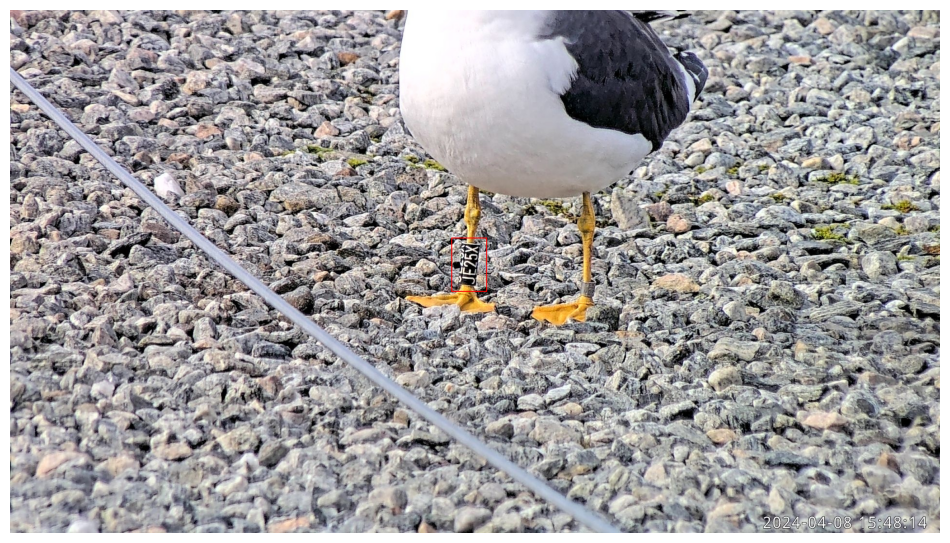

In [15]:
img, bb, l = exp_dataset[9]
print(bb)

draw_image_with_bb(img, bb)


In [8]:

bb_folder_path = "dataset/datasets/rf/labels"

def get_bbpath(filename, bb_folder_path):

    bb_path = bb_folder_path + "/" +  filename[:-4] + ".txt"
    
    return bb_path

filename = "20240408-145102.064779(162.29,-4.57,9209.0).jpg"

a = get_bbpath(filename=filename, bb_folder_path=bb_folder_path)

bb = bb_txt_to_list(a)

bb_cords = calculate_bb_cords(img, bb)
print(bb_cords)


(966.5432639999999, 546.6182400000001, 1034.384736, 659.34432)


In [9]:
# TODO: Crop bildene med de tilhørende bounding boxene
# Sjekk at det funker en drawimage funksjon



In [10]:
# TODO: Så tester vi modellen igjen

In [11]:

exp_loader = DataLoader(dataset=exp_dataset, batch_size=64, shuffle=True)


In [12]:
def prediction(dataloader):
    for images, labels in dataloader:
        images = BWDatasets.tensor_to_numpy(images)
        labels = labels[0]
        for i, image in enumerate(images):
            result = ocr.predict(image)

            print("-------------------")
            print(f'Prediction: {result[0]["rec_texts"]}')
            print(f'Actual: {labels[i]}')



In [13]:
prediction(exp_loader)



ValueError: too many values to unpack (expected 2)